# Мобильные приложения —  Выделение групп пользователей на основе поведения

## Описание данных:
Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.
В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет mobile_dataset.csv содержит колонки:
   - event.time  — время совершения
   - event.name  — название события
   - user.id  — идентификатор пользователя

Датасет mobile_sources.csv содержит колонки:
   - userId  — идентификатор пользователя
   - source  — источник, с которого пользователь установил приложение

Расшифровки событий:
    
    - advert_open  — открытие карточки объявления
    - photos_show  — просмотр фотографий в объявлении
    - tips_show  — пользователь увидел рекомендованные объявления
    - tips_click  — пользователь кликнул по рекомендованному объявлению
    - contacts_show  и  show_contacts  — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
    - contacts_call  — пользователь позвонил по номеру телефона на карточке объявления
    - map  — пользователь открыл карту размещенных объявлений
    - search_1  —  search_7  — разные события, связанные с поиском по сайту
    - favorites_add  — добавление объявления в избранное

В рамках исследования необходимо ответить на следующие вопросы:

- Какие пользователи склонны часто возвращаться в мобильное приложение?
- Какие пользователи часто делают целевое событие (contacts_show)?
- Как различается время между распространенными событиями пользователей, (например, различаются ли пользователи по группам на основе времени, которое проходит с момента первого использования мобильного приложения и до использования функции поиска)?

##  Загрузка данных и подготовка их к анализу


In [1]:
# импорт библиотек
import pandas as pd
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math as mth
from scipy import stats as st


In [2]:
# загрузка и просмотр данных
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')


In [3]:
mobile_sourсes.head()


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [5]:
#переименовываем названия столбцов
mobile_sourсes.rename(columns={'userId':'user_id'}, inplace = True)

In [6]:
mobile_dataset.rename(columns={'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'}, inplace=True)

In [7]:
#просматриваем информацию о данных в таблице mobile_sources
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Пустых значений не выявлено, тип данных совпадает с необходимым

In [8]:
#просматриваем информацию о данных в таблице mobile_dataset
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Пустых значений не выявлено, тип данных у столбца event.time не совпадает с необходимым дате

In [9]:
# меняем форматы столбца с датой на необходимый
mobile_dataset['event_time']=pd.to_datetime(mobile_dataset['event_time'], format='%Y-%m-%d %H:%M:%S')

In [10]:
# округляем значения столбца с датой до секунд
mobile_dataset['event_time'] = mobile_dataset['event_time'].dt.round('s')

In [11]:
# проверяем на наличие дубликатов
mobile_dataset.duplicated().sum() 

1118

In [12]:
#удаляем дубликаты
mobile_dataset = mobile_dataset.drop_duplicates().reset_index(drop=True) 

In [13]:
# проверяем на наличие дубликатов
mobile_sourсes.duplicated().sum()

0

In [14]:
#просматриваем информацию о данных в таблице mobile_dataset
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73079 entries, 0 to 73078
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  73079 non-null  datetime64[ns]
 1   event_name  73079 non-null  object        
 2   user_id     73079 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [15]:
# объединим данные в одну таблицу
mobile_dataset=mobile_dataset.merge(mobile_sourсes, on = 'user_id', how = 'left')

In [16]:
# добавим новые столбцы с датой и неделей  события
mobile_dataset['date'] = mobile_dataset['event_time'].dt.date
mobile_dataset['week'] = mobile_dataset['event_time'].dt.isocalendar().week


In [17]:
mobile_dataset.head()

,event_time,event_name,user_id,source,date,week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,41
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,41


In [18]:
#просматриваем какие события у нас имеются
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Так как более подробных деталей у событий search_1 -search_7 у нас не имеется, принято решение заменить название этих событий на search.
Также событий contacts_show и show_contacts замененяется на одно.

In [19]:
# заменяем значения 'show_contacts'в столбце event_name на 'contacts_show'
mobile_dataset.loc[(mobile_dataset['event_name']=='show_contacts'), 'event_name']='contacts_show'


In [20]:
# заменяем значения search_1 -search_7  на search
search=['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']
for i in search:
    mobile_dataset.loc[(mobile_dataset['event_name']==i), 'event_name']='search'


### Вывод по загрузке и подготовке данных
В рамках подготовки данных:
- были удалены дубликаты в таблице mobile_dataset;
- исправлен формат данных со временем на необходимый, а также округлена дата до секунды;
- изменены названия столбцов в соответсвие со змеиным регистром;
- пустых значений не выявлено;
- данные объединены в один датафрейм;
- переименовали события.

## Исследовательский анализ данных

In [21]:
# просматриваем начало периода наблюдений
mobile_dataset['event_time'].min()


Timestamp('2019-10-07 00:00:00')

In [22]:
# просматриваем конец периода наблюдений
mobile_dataset['event_time'].max()

Timestamp('2019-11-03 23:58:13')

Имеются данные с 7 октября 2019 года по 3 ноября 2019 года - 28 дней

In [23]:
# просматриваем сколько пользователей пришло с каждого источника
mobile_dataset.groupby('source')['user_id'].nunique()


source
google    1129
other     1230
yandex    1934
Name: user_id, dtype: int64

Больше всего клиентов приходит из yandex

In [77]:
# просматриваем количество пользователей на каждом событии
c=mobile_dataset.groupby('event_name')['user_id'].count().sort_values(ascending=False).reset_index()
c = c.set_index('event_name')
c


,user_id
event_name,
tips_show,39892
photos_show,9372
search,6766
advert_open,6145
contacts_show,4381
map,3760
favorites_add,1414
tips_click,811
contacts_call,538


Самое популярное событие - tips_show (пользователь увидел рекомендованное объявление).
Затем пользователи чаще всего просматривает фотографию в объявлении (photos_show) - 9372 раза. Целевое событие contacts_show (просмотр номер телефона) совершает только 4381 раз. Карту просматривает небольшое количество пользователей - 3760, в избранное добавляют также небольшое количество пользователей - 1414

Скорее всего события происходят в следующем порядке:

Если пользователь пришел по рекомендованном объявлению:
- tips_show  — пользователь увидел рекомендованные объявления
- tips_click  — пользователь кликнул по рекомендованному объявлению
- photos_show  — просмотр фотографий в объявлении
- contacts_show  — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- contacts_call  — пользователь позвонил по номеру телефона на карточке объявления
- favorites_add  — добавление объявления в избранное

Если пользователь сам пришел на сайт:

- search - разные события, связанные с поиском по сайту
- map  — пользователь открыл карту размещенных объявлений 
- advert_open  — открытие карточки объявления
- photos_show  — просмотр фотографий в объявлении
- contacts_show — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- contacts_call  — пользователь позвонил по номеру телефона на карточке объявления  
- favorites_add  — добавление объявления в избранное  



Text(0.5, 0, 'Дата')

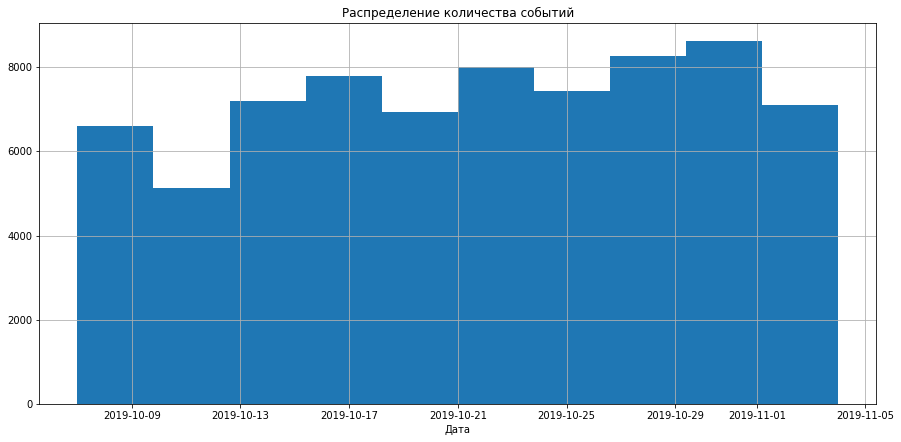

In [25]:
#просмотрим количество событий по дням
mobile_dataset['event_time'].hist( figsize=(15,7))
plt.title('Распределение количества событий')
plt.xlabel('Дата')


В течение  всего времени больше всего количества событий выявлено 1 ноября, меньше всего - 11 октября, однако в принципе приложение работало стабильно, резких скачков с действиями в приложении не выявлено.

In [26]:
# посмотрим общее количество событий 
mobile_dataset.shape[0]

73079

In [27]:
# посмотрим  количество  уникальных пользователей 
mobile_dataset['user_id'].nunique()

4293

In [28]:
#посмотрим на среднее количество событий на одного пользователя
mobile_dataset.shape[0]/ mobile_dataset['user_id'].nunique()

17.022827859305846

В среднем один пользователь совершает по 17 событий.

In [29]:
# рассчитаем DAU и WAU (количество уникальных пользователей в день и в неделю)
dau_total = mobile_dataset.groupby('date').agg({'user_id':'nunique'}).mean()
wau_total = mobile_dataset.groupby('week').agg({'user_id':'nunique'}).mean()
print('Количество уникальных пользователей в день - ', int(dau_total))
print('Количество уникальных пользователей в неделю - ', int(wau_total))

Количество уникальных пользователей в день -  279
Количество уникальных пользователей в неделю -  1382


In [30]:
#посмотрим информацию о событиях для каждого пользователя
ev=mobile_dataset.groupby('user_id').agg({'event_name':'count'}).reset_index()
ev.describe()

,event_name
count,4293.000000
mean,17.022828
std,28.617646
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,472.000000


При среднем количестве событий на каждого пользователя - 17, видим, что медианное значение количесвта событий равно 9.

Text(0.5, 0, 'События')

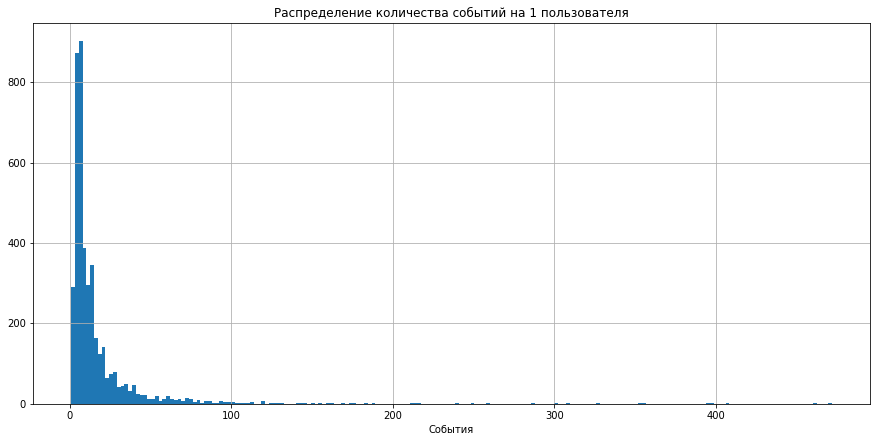

In [31]:
mobile_dataset.groupby('user_id').agg({'event_name':'count'}).hist(bins=200, figsize=(15,7))
plt.title('Распределение количества событий на 1 пользователя')
plt.xlabel('События')

На графике видно, что есть пользователи которые совершают больше 200 событий, и даже больше 400. Однако большинство пользователей совершают не больше 20 событий.

### Вывод по исследовательскому анализу данных

Анализируя данные, отмечаем что имеем сведения  с 7 октября 2019 года по 3 ноября 2019 года - всего за 28 дней

Клиентов, пришедших с  yandex больше - 45 процентов.

Общее количество событий - 73079, в течение  всего времени больше всего количества событий выявлено 1 ноября, меньше всего - 11 октября, однако в принципе приложение работало стабильно, резких скачков с действиями в приложении не выявлено.

Всего 4293 клиента, в среднем на клиента приходится 17 событий, однако медианное количество событий составляет  9, так как имеются значительные выбросы в 200 и даже в 472 события.

Количество уникальных пользователей в день -  279

Количество уникальных пользователей в неделю -  1382



## Сегментирование пользователей на 2 группы

### Разделим пользователей на 2 группы

Делить пользователей будем по количеству действий, совершаемых ими в рамках одной сессии(до медианного значения и после). Данный подход связан с гипотезой, что чем глубже, больше действий выполняет пользователь в рамках использования приложения, тем оно интереснее для клиента и тем дольше клиент остается с приложением.

Далее выделим сесии по 20 минут, так как именно столько примерно понадобится клиенту на список действий(просмотр объявления, фотографий, карты, открытия карточки...) если на каждое объявление необходимо 2-3 минуты. то клиент сможет просмотреть от 6 до 10 объявлений.


In [32]:
#Выделяем сессии

g = (mobile_dataset.groupby('user_id')['event_time'].diff() > pd.Timedelta('20Min')).cumsum()

#create counter of groups
mobile_dataset['session_id'] = mobile_dataset.groupby(['user_id', g], sort=False).ngroup() + 1
mobile_dataset.head()

,event_time,event_name,user_id,source,date,week,session_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41,1
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41,1
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,41,2
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41,1
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,41,2


In [33]:
#просмотрим сколько событий происходит в каждую сессию
session=mobile_dataset.groupby('session_id')['event_name'].count().reset_index()
display(session)

,session_id,event_name
0,1,28
1,2,25
2,3,19
3,4,2
4,5,33
...,...,...
27980,27981,2
27981,27982,4
27982,27983,6
27983,27984,1


In [34]:
session.describe()

,session_id,event_name
count,27985.000000,27985.000000
mean,13993.000000,2.611363
std,8078.717978,2.844422
min,1.000000,1.000000
25%,6997.000000,1.000000
50%,13993.000000,2.000000
75%,20989.000000,3.000000
max,27985.000000,63.000000


Максимальное количество событий в сесии - 63, минимальное - 1, среднее медианное значение - 2,6. Разделим пользователей на 2 группы: тех, кто совершил в рамках одной сессии 2 и менее события, и тех, кто совершил 3 и более события.

In [35]:
#выделим сессии, в которых количество событий меньше либо равно 2
session_1=session.loc[session['event_name']<3]
display(session_1)


,session_id,event_name
3,4,2
9,10,1
15,16,1
19,20,1
22,23,1
...,...,...
27978,27979,1
27979,27980,1
27980,27981,2
27983,27984,1


In [36]:
#выделим сессии, в которых количество событий больше 2
session_2=session.loc[session['event_name']>2]
display(session_2)

,session_id,event_name
0,1,28
1,2,25
2,3,19
4,5,33
5,6,22
...,...,...
27971,27972,3
27972,27973,4
27977,27978,3
27981,27982,4


In [37]:
# изменим столбец с индексами и вместо цифровых значений зададим данные из столбца «session_id»:
df = mobile_dataset.set_index('session_id')

In [38]:
# выведим в отдельную группу пользователей, у которых количество событий не превышает двух
mobile_dataset_1=df.drop(session_2['session_id'].to_list(),axis = 0)
# сбросим индекс
mobile_dataset_1=mobile_dataset_1.reset_index()
# просмотрим данные 
mobile_dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25215 entries, 0 to 25214
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   session_id  25215 non-null  int64         
 1   event_time  25215 non-null  datetime64[ns]
 2   event_name  25215 non-null  object        
 3   user_id     25215 non-null  object        
 4   source      25215 non-null  object        
 5   date        25215 non-null  object        
 6   week        25215 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), int64(1), object(4)
memory usage: 1.3+ MB


In [39]:
# выведим в отдельную группу пользователей, у которых количество событий больше двух
mobile_dataset_2=df.drop(session_1['session_id'].to_list(),axis = 0)
# сбросим индекс
mobile_dataset_2=mobile_dataset_2.reset_index()
#посмотрим данные
mobile_dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47864 entries, 0 to 47863
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   session_id  47864 non-null  int64         
 1   event_time  47864 non-null  datetime64[ns]
 2   event_name  47864 non-null  object        
 3   user_id     47864 non-null  object        
 4   source      47864 non-null  object        
 5   date        47864 non-null  object        
 6   week        47864 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), int64(1), object(4)
memory usage: 2.4+ MB


### Сравним Retention rate по группам

In [40]:
#добавим солбцы с датой первого визита и начальной датой сессии
mobile_dataset_1['first_visit'] = mobile_dataset_1.groupby('user_id')['event_time'].transform('min')
mobile_dataset_1['session_start'] = mobile_dataset_1.groupby(['user_id', 'session_id'])['event_time'].transform('min')
mobile_dataset_2['first_visit'] = mobile_dataset_2.groupby('user_id')['event_time'].transform('min')
mobile_dataset_2['session_start'] = mobile_dataset_2.groupby(['user_id', 'session_id'])['event_time'].transform('min')

In [41]:
# Зададим функция расчета retention rate
def get_retention(df, observation_date, horizon_days, ignore_horizon=False):
    
    df['first_day'] = df['first_visit'].dt.date

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    df = df.query('first_day <= @last_suitable_acquisition_date')

    df['lifetime'] = (
        df['session_start'] - df['first_visit']
    ).dt.days
    
    

    # рассчитываем удержание
    result_grouped = df.pivot_table(
        index='first_day', columns='lifetime', values='user_id', aggfunc='nunique'
    )
    
    cohort_sizes = (
        df.groupby('first_day')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    
    result_grouped = cohort_sizes.merge(
        result_grouped, on='first_day', how='left'
    ).fillna(0)
    
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)
    
    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]
   
    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes.sum()

    # возвращаем таблицу удержания 
    return result_grouped

In [42]:
#Задаем момент анализа
observation_date = mobile_dataset['event_time'].max()  # момент анализа

# горизонт анализа
analysis_horizon = 7

In [43]:
#применим функцию retention rate к первой группе пользователей
retention_1=get_retention(mobile_dataset_1, observation_date, analysis_horizon)
display(retention_1)

/tmp/ipykernel_64/890585614.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lifetime'] = (


,cohort_size,0,1,2,3,4,5,6
first_day,,,,,,,,
2019-10-07,NaN,1.0,0.131148,0.106557,0.114754,0.057377,0.024590,0.073770
2019-10-08,NaN,1.0,0.134921,0.111111,0.047619,0.055556,0.047619,0.039683
2019-10-09,NaN,1.0,0.088710,0.072581,0.048387,0.080645,0.064516,0.072581
2019-10-10,NaN,1.0,0.082645,0.099174,0.082645,0.123967,0.074380,0.074380
2019-10-11,NaN,1.0,0.052632,0.105263,0.096491,0.105263,0.078947,0.078947
2019-10-12,NaN,1.0,0.111111,0.133333,0.022222,0.044444,0.066667,0.066667
2019-10-13,NaN,1.0,0.147287,0.069767,0.054264,0.062016,0.054264,0.077519
2019-10-14,NaN,1.0,0.092025,0.092025,0.104294,0.085890,0.067485,0.030675
2019-10-15,NaN,1.0,0.135484,0.096774,0.090323,0.058065,0.058065,0.090323


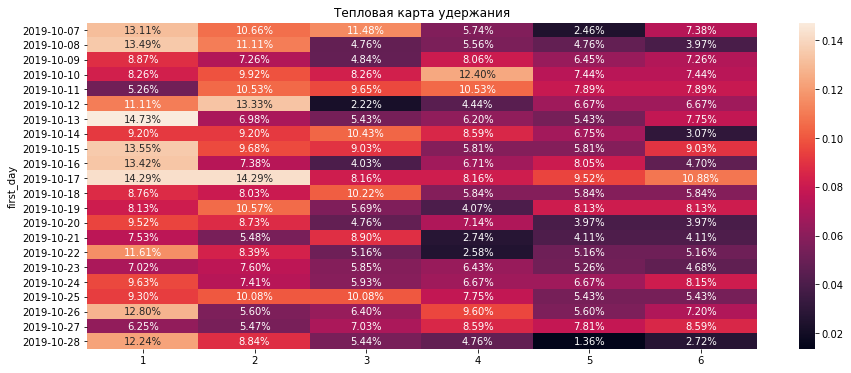

In [44]:
#построим тепловую карту удержания для первой группы
plt.figure(figsize = (15, 6))  # задаём размер графика
sns.heatmap(retention_1.drop(columns = ['cohort_size', 0]), # удаляем размеры когорты и нулевой лайфтайм
            annot = True,  # включаем подписи
            fmt = '.2%'  # отображаем значения в виде процентов
           )
plt.title('Тепловая карта удержания')  # название графика
plt.show()

In [45]:
#применим функцию retention rate ко второй группе пользователей
retention_2=get_retention(mobile_dataset_2, observation_date, analysis_horizon)

/tmp/ipykernel_64/890585614.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lifetime'] = (


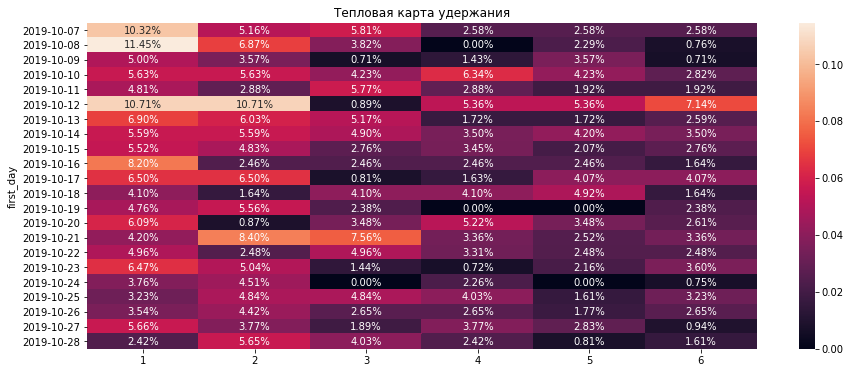

In [46]:
#построим тепловую карту удержания для второй группы
plt.figure(figsize = (15, 6))  # задаём размер графика
sns.heatmap(retention_2.drop(columns = ['cohort_size', 0]), # удаляем размеры когорты и нулевой лайфтайм
            annot = True,  # включаем подписи
            fmt = '.2%'  # отображаем значения в виде процентов
           )
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Анализируя карту удержания, можно увидеть, что вторая карта более темная, то есть пользователи со второй группы удерживаются хуже.

### Сравним пользователей по метрике "Время в приложении"

In [47]:
# посмотрим на максимальное время по каждому пользователю и сессии 1ой группы пользователей
duration_time_1= mobile_dataset_1.groupby(['user_id', 'session_id'])['event_time'].max().reset_index()

# посмотрим на минимальное время по каждому пользователю и сессии 1ой группы пользователей
b=mobile_dataset_1.groupby(['user_id', 'session_id'])['event_time'].min().reset_index()

# посчитаем продолжительность времени сессий для 1ой группы пользователей
duration_time_1['duration_time']=duration_time_1['event_time']-b['event_time']
#меняем формат столбца duration_time
duration_time_1['duration_time']=duration_time_1['duration_time'].dt.total_seconds()
duration_time_1.describe()

,session_id,duration_time
count,18903.000000,18903.000000
mean,14569.877586,26.218960
std,7881.230076,66.166783
min,4.000000,0.000000
25%,7922.500000,0.000000
50%,14708.000000,0.000000
75%,21373.500000,16.000000
max,27985.000000,1171.000000


Рассматривая описание столбца duration_time, отмечаем, что 50% пользователей имеют 0 продолжительность времени, то есть совершают по 1 действию. Принято решение их удалить.

In [48]:
#удаляем нулевые значения  в столбце duration_time
duration_time_1=duration_time_1.loc[duration_time_1['duration_time']!=0]
duration_time_1.describe()


,session_id,duration_time
count,6300.000000,6300.000000
mean,14159.299206,78.669365
std,7974.019018,94.924758
min,4.000000,1.000000
25%,7243.250000,16.000000
50%,14054.500000,51.000000
75%,21074.000000,107.000000
max,27985.000000,1171.000000


array([[<AxesSubplot:title={'center':'duration_time'}>]], dtype=object)

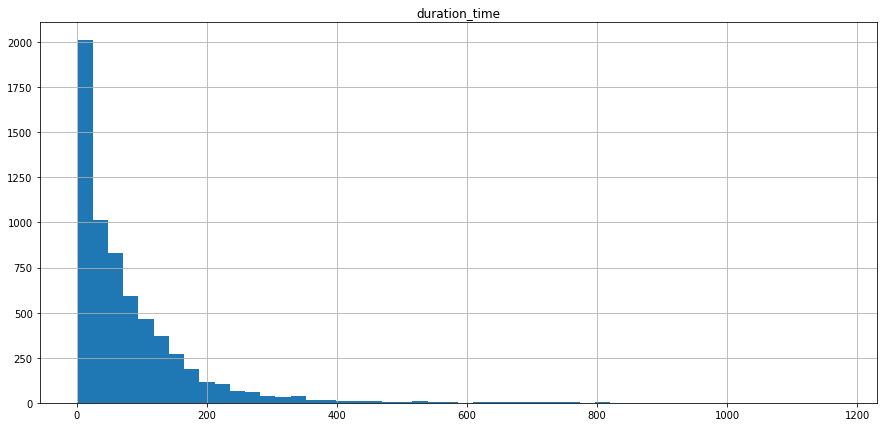

In [49]:
#построим гистограмму распределения продолжительности времени
duration_time_1.hist('duration_time', figsize=(15,7), bins=50)

In [50]:
# посмотрим на максимальное время по каждому пользователю и сессии 2ой группы пользователей
duration_time_2= mobile_dataset_2.groupby(['user_id', 'session_id'])['event_time'].max().reset_index()

# посмотрим на минимальное время по каждому пользователю и сессии 1ой группы пользователей
c=mobile_dataset_2.groupby(['user_id', 'session_id'])['event_time'].min().reset_index()

# посчитаем продолжительность времени сессий для 1ой группы пользователей
duration_time_2['duration_time']=duration_time_2['event_time']-c['event_time']
#меняем формат столбца duration_time
duration_time_2['duration_time']=duration_time_2['duration_time'].dt.total_seconds()
duration_time_2.describe()

,session_id,duration_time
count,9082.000000,9082.000000
mean,12792.304448,281.187514
std,8348.589682,302.374912
min,1.000000,2.000000
25%,5223.250000,101.000000
50%,12213.500000,197.000000
75%,19841.250000,356.000000
max,27983.000000,8207.000000


array([[<AxesSubplot:title={'center':'duration_time'}>]], dtype=object)

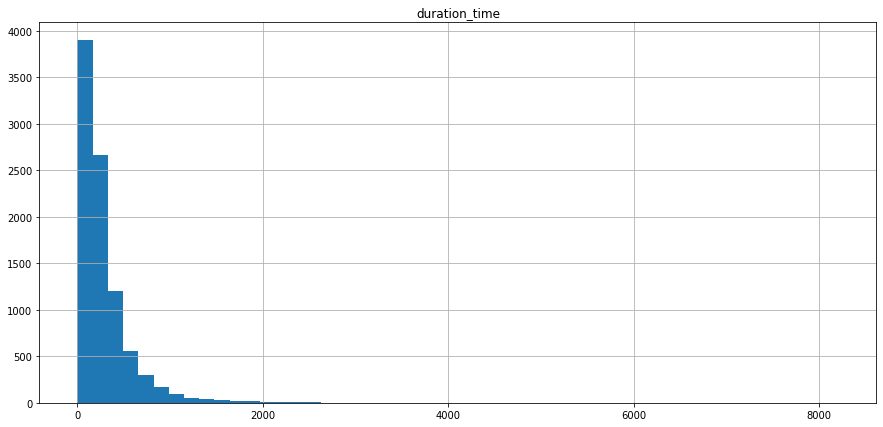

In [51]:
#построим гистограмму распределения продолжительности времени
duration_time_2.hist('duration_time', figsize=(15,7), bins=50)

Анализируя распределение продолжительности времени, затрачиваемое пользователями, отмечаем, что у второй группы  cредние показатели (арифметическое среднее и медианы), а также максимальное время пользования  выше.

### Сравнение групп по метрике "Конверсия в целевое действие contacts_show"

Выберем из данных 1 ой группы только тех пользователей, которые совершили событие "contacts_show"

In [52]:
# посчитаем количество уникальных пользователей в группе 1
users_1=mobile_dataset_1['user_id'].nunique()

#создадим датасет из пользователей 1 группы, посмотревших контакты
contacts_show_1=mobile_dataset_1.loc[mobile_dataset_1['event_name']=='contacts_show']
# посчитаем количество пользователей в 1 группе, посмотревших контакты
users_1_cs=contacts_show_1['user_id'].nunique()

#посчитаем конверсию пользователей из 1 группы, посмотревших контакты, от общего числа

print('Конверсия в целевое действие contacts_show 1 группы:', users_1_cs/users_1)

Конверсия в целевое действие contacts_show 1 группы: 0.18149270173505921


In [53]:
# посчитаем количество уникальных пользователей в группе 2
users_2=mobile_dataset_2['user_id'].nunique()

#создадим датасет из пользователей 2 группы, посмотревших контакты
contacts_show_2=mobile_dataset_2.loc[mobile_dataset_2['event_name']=='contacts_show']
# посчитаем количество пользователей во 2 группе, посмотревших контакты
users_2_cs=contacts_show_2['user_id'].nunique()

#посчитаем конверсию пользователей из 2 группы, посмотревших контакты, от общего числа

print('Конверсия в целевое действие contacts_show 2 группы:', users_2_cs/users_2)

Конверсия в целевое действие contacts_show 2 группы: 0.1882734236888627


Конверсия в целевое действие contacts_show обоих групп примерно одинаковая, у 2 группы чуть лучше (на 1 процент)

### Сравнение групп  по времени между действиями

In [54]:
#просмотрим самые популярные действия пользователей
pop_event=mobile_dataset.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
                  
pop_event

,event_name,user_id
8,tips_show,2801
6,search,1666
4,map,1456
5,photos_show,1095
2,contacts_show,981
0,advert_open,751
3,favorites_add,351
7,tips_click,322
1,contacts_call,213


 Самые популярные действия - это просмотр рекомендованных объявлений (tips_show) и поиск (search)

#### Сравнение групп по времени между первым заходом в приложение и выполнением действия search

In [55]:
#просмотрим первое время визита пользователей с 1 группы
users_first_visit_1=mobile_dataset_1.groupby('user_id')['first_visit'].min().reset_index()

#просмотрим пользователей с 1 группы, выполнивших событий search
search_dataset_1=mobile_dataset_1.loc[mobile_dataset_1['event_name']=='search']
#просмотрим время первого выполнения события search у 1 группы
users_first_visit_search_1=search_dataset_1.pivot_table(index = ['user_id'],values = 'event_time', aggfunc = 'first').reset_index()
#переименуем столбец
users_first_visit_search_1.rename(columns={'event_time':'first_search_time'}, inplace = True)
users_first_visit_search_1.head()  

,user_id,first_search_time
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06
2,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-28 13:08:16
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,2019-10-23 08:53:33
4,00a93a72-3bbc-4ee7-8a81-7134f45ae009,2019-10-11 15:45:00


In [56]:
#соединим таблицы с пользователям из 1 группы, а именно даты первого захода в приложение и дату первого просмотра события search
search_1 = users_first_visit_search_1.merge(users_first_visit_1, on = 'user_id', how = 'left')
#посчитаем разницу дат
search_1['diff_time']=search_1['first_search_time']-search_1['first_visit']

print('''Среднее значение времени, которое проходит с момента первого использования 
      мобильного приложения и до использования функции поиска у пользователей 1 группы:''', search_1['diff_time'].mean())

Среднее значение времени, которое проходит с момента первого использования 
      мобильного приложения и до использования функции поиска у пользователей 1 группы: 0 days 20:51:20.874298540


In [57]:
#просмотрим первое время визита пользователей со 2 группы
users_first_visit_2=mobile_dataset_2.groupby('user_id')['first_visit'].min().reset_index()

#просмотрим пользователей со 2 группы, выполнивших событий search
search_dataset_2=mobile_dataset_2.loc[mobile_dataset_2['event_name']=='search']
#просмотрим время первого выполнения события search у 2 группы
users_first_visit_search_2=search_dataset_2.pivot_table(index = ['user_id'],values = 'event_time', aggfunc = 'first').reset_index()
#переименуем столбец
users_first_visit_search_2.rename(columns={'event_time':'first_search_time'}, inplace = True)
users_first_visit_search_2.head() 

,user_id,first_search_time
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29 21:18:25
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-20 17:47:19
2,00554293-7e00-4122-b898-4e892c4a7c53,2019-10-27 12:32:28
3,00a93a72-3bbc-4ee7-8a81-7134f45ae009,2019-10-11 15:41:11
4,00aa4003-366b-4788-ad1f-506f2b51b8cb,2019-10-18 22:23:28


In [58]:
#соединим таблицы с пользователям из 2 группы, а именно даты первого захода в приложение и дату первого просмотра события search
search_2 = users_first_visit_search_2.merge(users_first_visit_2, on = 'user_id', how = 'left')
#посчитаем разницу дат
search_2['diff_time']=search_2['first_search_time']-search_2['first_visit']

print('''Среднее значение времени, которое проходит с момента первого использования 
      мобильного приложения и до использования функции поиска у пользователей 2 группы:''', search_2['diff_time'].mean())

Среднее значение времени, которое проходит с момента первого использования 
      мобильного приложения и до использования функции поиска у пользователей 2 группы: 0 days 10:18:32.836409395


#### Сравнение групп по времени между первым заходом в приложение и выполнением действия tips_show

In [59]:
#просмотрим пользователей с 1 группы, выполнивших событий tips_show
tips_show_dataset_1=mobile_dataset_1.loc[mobile_dataset_1['event_name']=='tips_show']
#просмотрим время первого выполнения события tips_show у 1 группы
users_first_visit_tips_show_1=tips_show_dataset_1.pivot_table(index = ['user_id'],values = 'event_time', aggfunc = 'first').reset_index()
#переименуем столбец
users_first_visit_tips_show_1.rename(columns={'event_time':'first_tips_show_time'}, inplace = True)
users_first_visit_tips_show_1.head()  

,user_id,first_tips_show_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22 11:19:11
1,00554293-7e00-4122-b898-4e892c4a7c53,2019-10-27 12:37:44
2,005fbea5-2678-406f-88a6-fbe9787e2268,2019-10-11 11:29:10
3,007d031d-5018-4e02-b7ee-72a30609173f,2019-10-22 13:04:20
4,00ba2474-01c3-481a-8cf2-6d4636a8a1ca,2019-10-15 22:20:52


In [60]:
#соединим таблицы с пользователям из 1 группы, а именно даты первого захода в приложение и дату первого просмотра события tips_show
tips_show_1 = users_first_visit_tips_show_1.merge(users_first_visit_1, on = 'user_id', how = 'left')
#посчитаем разницу дат
tips_show_1['diff_time']=tips_show_1['first_tips_show_time']-tips_show_1['first_visit']

print('''Среднее значение времени, которое проходит с момента первого использования 
      мобильного приложения и до использования функции tips_show у пользователей 1 группы:''', tips_show_1['diff_time'].mean())

Среднее значение времени, которое проходит с момента первого использования 
      мобильного приложения и до использования функции tips_show у пользователей 1 группы: 0 days 04:35:48.253953908


In [61]:
#просмотрим пользователей со 2 группы, выполнивших событий tips_show
tips_show_dataset_2=mobile_dataset_2.loc[mobile_dataset_2['event_name']=='tips_show']
#просмотрим время первого выполнения события tips_show у 2 группы
users_first_visit_tips_show_2=tips_show_dataset_2.pivot_table(index = ['user_id'],values = 'event_time', aggfunc = 'first').reset_index()
#переименуем столбец
users_first_visit_tips_show_2.rename(columns={'event_time':'first_tips_show_time'}, inplace = True)
users_first_visit_tips_show_2.head()  

,user_id,first_tips_show_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-20 17:48:42
2,00554293-7e00-4122-b898-4e892c4a7c53,2019-10-27 12:33:13
3,007d031d-5018-4e02-b7ee-72a30609173f,2019-10-22 13:06:58
4,009c0f37-8556-4c72-a007-100e28a37373,2019-10-20 02:05:28


In [62]:
#соединим таблицы с пользователям из 2 группы, а именно даты первого захода в приложение и дату первого просмотра события tips_show
tips_show_2 = users_first_visit_tips_show_2.merge(users_first_visit_2, on = 'user_id', how = 'left')
#посчитаем разницу дат
tips_show_2['diff_time']=tips_show_2['first_tips_show_time']-tips_show_2['first_visit']

print('''Среднее значение времени, которое проходит с момента первого использования 
      мобильного приложения и до использования функции tips_show у пользователей 2 группы:''', tips_show_2['diff_time'].mean())

Среднее значение времени, которое проходит с момента первого использования 
      мобильного приложения и до использования функции tips_show у пользователей 2 группы: 0 days 01:45:50.817903930


Как видим у второй группы разница между временем первого захода в приложение и временем совершения популярных действий search и tips_show значительно ниже, чем у 1 группы

### Выводы по сегментированию пользователей на 2 группы
В рамках сегментирования пользователей на 2 группы было выбрано разделение с учетом количества действий, соверщаемых в рамках сессий (до медианного значения и после). Так группы были поделены на тех, кто совершает 2 действия и меньше в рамках одной сессии, и на тех, кто совершает 3 и более действия.

Сравнивая показатель удержания Retention Rate, отметили, что пользователи со второй группы удерживаются хуже.

Сравнивая показатель "Время в приложении", отмечаем, что у второй группы более равномерно распределено время(меньше резких скачков). Средние показатели (арифметическое среднее и медианы), а также максимальное время пользования у второй группы также выше.

Показатель "Конверсия в целевое действие contacts_show" у обоих групп одинаковый - 18 процентов.

У второй группы разница между временем первого захода в приложение и временем совершения популярных действий search и tips_show значительно ниже, чем у 1 группы

Таким образом, не смотря на то, что 2 группа дольше и активнее пользуется приложением, их удержание ниже, чем у тех, кто совершает 1-2 действия во время пользования приложением. Возможно, 1ой группе нравится приложение и они быстро находят что им надо и возвращаются с удовольствием назад.

## Проверка статистических гипотез

### Проверка гипотезы: "Группы, установившие приложение из yandex и из google, демонстрируют разную конверсию в просмотры контактов."

Для проведения проверки гипотезы будем проводить z-тест, так как решаем задачу сравнения долей. Разница между долями, наблюдаемыми на выборках, будет нашей статистикой. Уровень значимости выберем -0.05

Формируем гипотезы:

H0:  конверсия в просмотры контактов у пользователей, установивших приложение из yandex и из google не отличается.

H1:  конверсия в просмотры контактов у пользователей, установивших приложение из yandex и из google отличается.

In [63]:
# напишем функцию для проведения z-теста
 
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    print('p-значение: ', p_value)
 
    if (p_value < alpha): 
        display('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')  

In [64]:
#посмотрим количество пользователей пришедших из google и yandex
sources=mobile_dataset.groupby('source')['user_id'].nunique().reset_index()
display(sources)

,source,user_id
0,google,1129
1,other,1230
2,yandex,1934


In [65]:
#посмотрим на данные пользователей, посмотревших контакты
contacts_show=mobile_dataset.loc[mobile_dataset['event_name']=='contacts_show']
#посчитаем сколько данных контактов пришло из google, а сколько из yandex
contacts_show=contacts_show.groupby('source')['user_id'].nunique().reset_index()
display(contacts_show)

,source,user_id
0,google,275
1,other,228
2,yandex,478


In [66]:
#проведем z-тест
z_test(contacts_show.loc[0][1],
      contacts_show.loc[2][1],
      sources.loc[0][1],
      sources.loc[2][1])

p-значение:  0.8244316027993777


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

Таким образом, конверсия в просмотры контактов у пользователей, установивших приложение из yandex и из google не отличается.

### Проверка гипотезы: "Средняя длительность сессий между пользователями, установившим приложение из yandex и из google, различается между собой."

Для проверки используем t-тест.

H0 Нулевая гипотеза:Между средним значением длительности сессий между пользователями, установившим приложение из yandex и из google, нет существенной разницы

H1 Альтернативная гипотеза:  Существует значительная разница между средним значением длительности сессий между пользователями, установившим приложение из yandex и из google

In [67]:
#создадим данные о пользователях с yandex
yandex=mobile_dataset.loc[mobile_dataset['source']=='yandex']
#посмотрим на максимальное время пользователей с yandex по сессиям
yandex_max=yandex.groupby(['user_id', 'session_id'])['event_time'].max().reset_index()
#посмотрим на первое(минимальное) время пользователей с yandex по сессиям
yandex_min=yandex.groupby(['user_id', 'session_id'])['event_time'].min().reset_index()
#создадим пустой Датасет
yandex_duration_session=pd.DataFrame() 
# посчитаем длительность сессий у пользователей yandex
yandex_duration_session['duration']=yandex_max['event_time']-yandex_min['event_time']
#переводим длительность сессий в секунды
yandex_duration_session['duration']=yandex_duration_session['duration'].dt.total_seconds()
#удаляем нулевые значения в длительности
yandex_duration_session=yandex_duration_session.loc[yandex_duration_session['duration']!=0]
display(yandex_duration_session)

,duration
7,115.0
10,74.0
11,111.0
12,797.0
14,79.0
...,...
12868,111.0
12871,52.0
12873,44.0
12874,164.0


In [68]:
#создадим данные о пользователях с google
google=mobile_dataset.loc[mobile_dataset['source']=='google']
#посмотрим на максимальное время пользователей с google по сессиям
google_max=google.groupby(['user_id', 'session_id'])['event_time'].max().reset_index()
#посмотрим на первое(минимальное) время пользователей с google по сессиям
google_min=google.groupby(['user_id', 'session_id'])['event_time'].min().reset_index()
#создадим пустой Датасет
google_duration_session=pd.DataFrame() 
# посчитаем длительность сессий у пользователей google
google_duration_session['duration']=google_max['event_time']-google_min['event_time']
#переводим длительность сессий в секунды
google_duration_session['duration']=google_duration_session['duration'].dt.total_seconds()
display(google_duration_session)


,duration
0,11.0
1,0.0
2,83.0
3,0.0
4,0.0
...,...
7789,26.0
7790,138.0
7791,49.0
7792,0.0


In [69]:
alpha = .01 # задаём критический уровень статистической значимости

results =  st.ttest_ind(
    yandex_duration_session['duration'], 
    google_duration_session['duration'], equal_var=False) #проверяем гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) # выводим на экран получившеся p-значение)

if results.pvalue < alpha:# сравниваем получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу, среднее значение длительности сессий между пользователями, установившим приложение из yandex и из google, различается")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.2603810567856954e-157
Отвергаем нулевую гипотезу, среднее значение длительности сессий между пользователями, установившим приложение из yandex и из google, различается


## Общий вывод

Анализируя данные, отмечаем что имеем сведения  с 7 октября 2019 года по 3 ноября 2019 года - всего за 28 дней

Клиентов, пришедших с  yandex больше - 45 процентов. Пользователей, пришедших с google - 1129, это 26 процентов.

Общее количество событий - 73079, в течение  всего времени больше всего количества событий выявлено 1 ноября, меньше всего - 11 октября, однако в принципе приложение работало стабильно, резких скачков с действиями в приложении не выявлено.

Всего 4293 клиента, в среднем на клиента приходится 17 событий, однако медианное количество событий составляет  9, так как имеются значительные выбросы в 200 и даже в 472 события.

Количество уникальных пользователей в день -  279

Количество уникальных пользователей в неделю -  1382.

Для анализа конкретных метрик было принято решение разделить пользователей по количеству действия в сессии. Так максимальное количество событий в сесии - 63, минимальное - 1, среднее медианное значение - 2,6. Было принято решение разделить пользователей на 2 группы: тех, кто совершил в рамках одной сессии 2 и менее события, и тех, кто совершил 3 и более события.

    - Сравнивая показатель удержания Retention Rate, отметили, что пользователи со второй группы удерживаются хуже.

    - Сравнивая показатель "Время в приложении", отмечаем, что у второй группы более равномерно распределено время(меньше резких скачков). Средние показатели (арифметическое среднее и медианы), а также максимальное время пользования у второй группы также выше.

    - Показатель "Конверсия в целевое действие contacts_show" у обоих групп одинаковый - 18-19 процентов.

Таким образом, не смотря на то, что 2 группа дольше и активнее пользуется приложением, их удержание ниже, чем у тех, кто совершает 1-2 действия во время пользования приложением. Возможно, 1ой группе нравится приложение и они быстро находят что им надо и возвращаются с удовольствием назад.


В рамках проверки статистических гипотез было проверены 2 гипотезы:
- Группы, установившие приложение из yandex и из google, демонстрируют разную конверсию в просмотры контактов.
- Средняя длительность сессий между пользователями, установившим приложение из yandex и из google, различается между собой.

Вывод по проверке гипотез:
- Конверсия в просмотры контактов у пользователей, установивших приложение из yandex и из google не отличается.
- Среднее значение длительности сессий между пользователями, установившим приложение из yandex и из google, различается

Отвечая на вопросы заказчика:
- Какие пользователи склонны часто возвращаться в мобильное приложение?
        - Пользователи, которые совершают в рамках сессиий 1-2 действия склонны чаще возвращаться в мобильное приложение
- Какие пользователи часто делают целевое событие (contacts_show)?
        - Пользователи, совершающие меньше 2 действий в сессии и больше 2 сессий, одинаково часто делают целевое событие contacts_show
- Как различается время между распространенными событиями пользователей, (например, различаются ли пользователи по группам на основе времени, которое проходит с момента первого использования мобильного приложения и до использования функции поиска)?
        - У второй группы разница между временем первого захода в приложение и временем совершения популярных действий search и tips_show значительно ниже, чем у 1 группы.
        
Рекомендации по развитию приложения:

    - Стоит аккуратно подходть к внедрению новых возможностей, функций в приложении, так как в принципе фишками вроде просмотра на карте пользуется не так много пользователей. И отмечено, что пользователи с количеством действий больше, чем 2, меньше удерживаются в приложении. Скорее всего пользователям в приложении комфортнее выполнять меньше действий, чтобы получать достигнутое, в таком случае они дольше остаются пользователями приложения.
    - Стоит обратить внимание с какого источника приходят пользователи yandex или google. Среднее значение длительности сессий между данными пользователями различается. Необходимо более детально изучить данных потребителей. 